# Example for how to create pickles of maps

The idea of pickling is to preserve information in a not memory intensive way. One of its convenient uses is for plotting maps, because you can pickle an object such as a Basemap project (see example below), and this greatly increases the speed of plotting. 

For more info, see: https://docs.python.org/3/library/pickle.html

In [22]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cmocean
import numpy as np
import pickle
import time

%matplotlib notebook

Note that rather than the usual "%matplotlib inline", I use "%matplotlib notebook". This allows matplotlib to plot interactively within the Jupyter notebook and is thus far the only way I've been able to use pickled maps (here is an issue description: https://github.com/ipython/ipykernel/issues/231). Note that matplotlib notebook is also convenient if you are plotting something and would like to change the colormap without needing to re-run the cell each time.

First, I load my land mask and lons/lats to create the Basemap like usual:

In [15]:
mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
tmask = np.array(mesh.variables['tmask'])

cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 

Let's see how long it normally takes to create the Basemap plot:

<IPython.core.display.Javascript object>


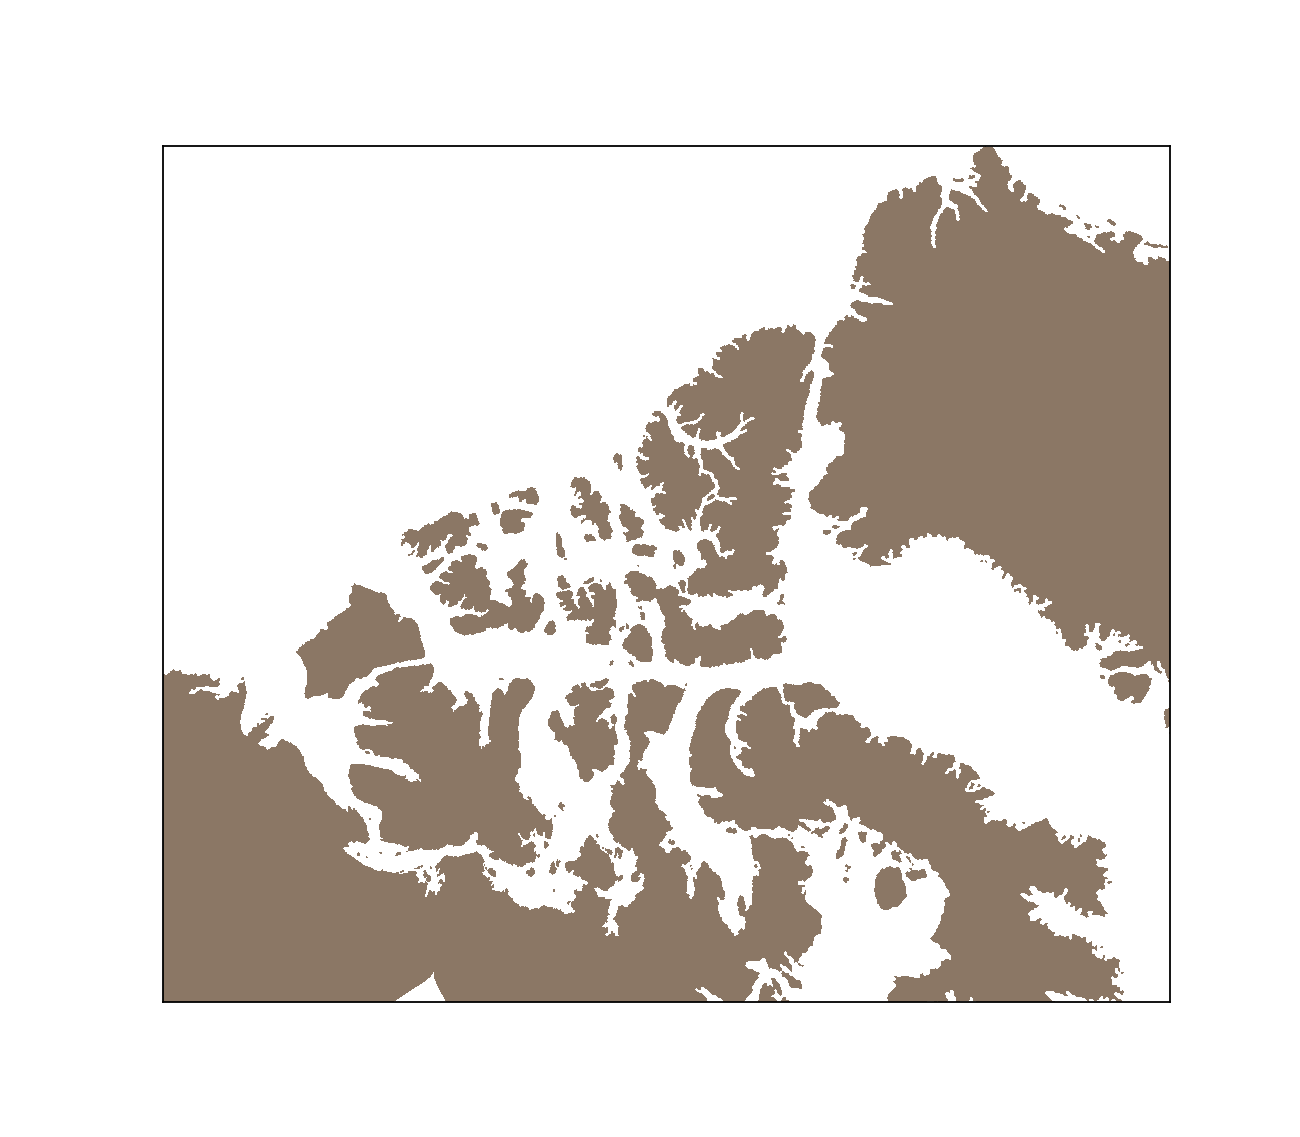

Time for plotting land mask without pickle:  7.170811078


In [16]:
t1 = time.process_time()

fig, ax1 = plt.subplots(figsize=(8,7))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=3.0e6, height=2.55e6, ax=ax1)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

print('Time for plotting land mask without pickle: ', time.process_time()-t1)

Now, let's create the pickle by typing: "pickle.dump(proj1,open('surface-map.pickle','wb'),-1)" where the first parameter is the object to pickle (the Basemap, proj1) and the second is the name to save the pickle to. 

<IPython.core.display.Javascript object>


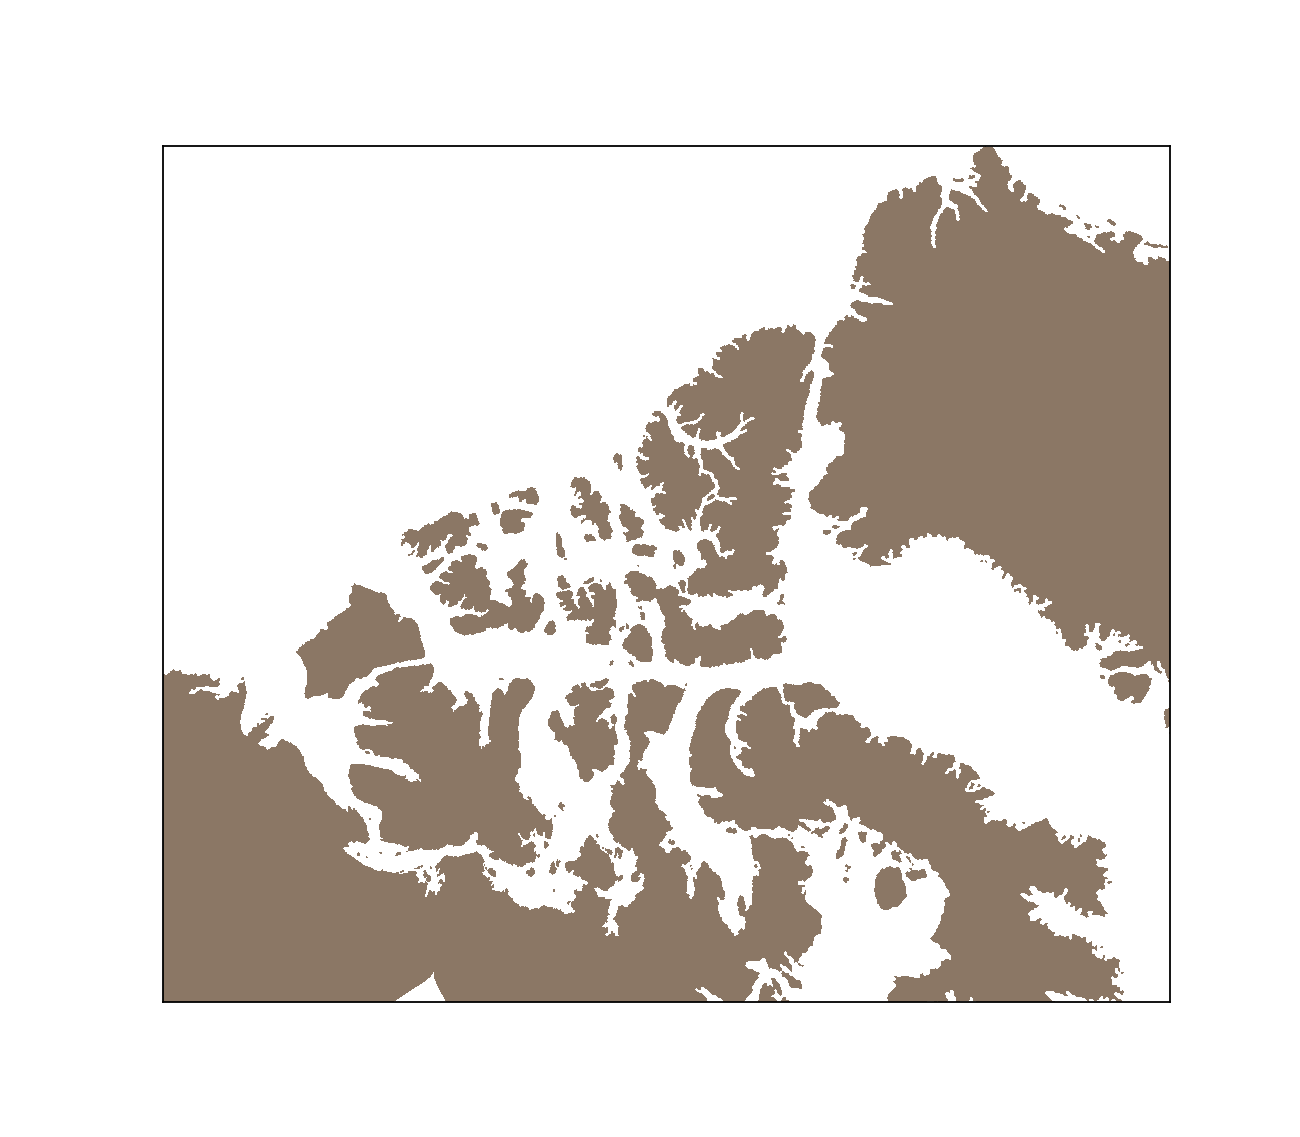

Time for plotting land mask and creating the pickle:  7.620030114999992


In [17]:
t2 = time.process_time()

fig, ax1 = plt.subplots(figsize=(8,7))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=3.0e6, height=2.55e6, ax=ax1)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]))

# pickle the class instance.
pickle.dump(proj1,open('surface-map.pickle','wb'),-1)

print('Time for plotting land mask and creating the pickle: ', time.process_time()-t2)

So, it takes very slightly longer to create the pickle and plot the land mask. Now, let's see how much faster it is to not have to plot the land mask each time:

<IPython.core.display.Javascript object>


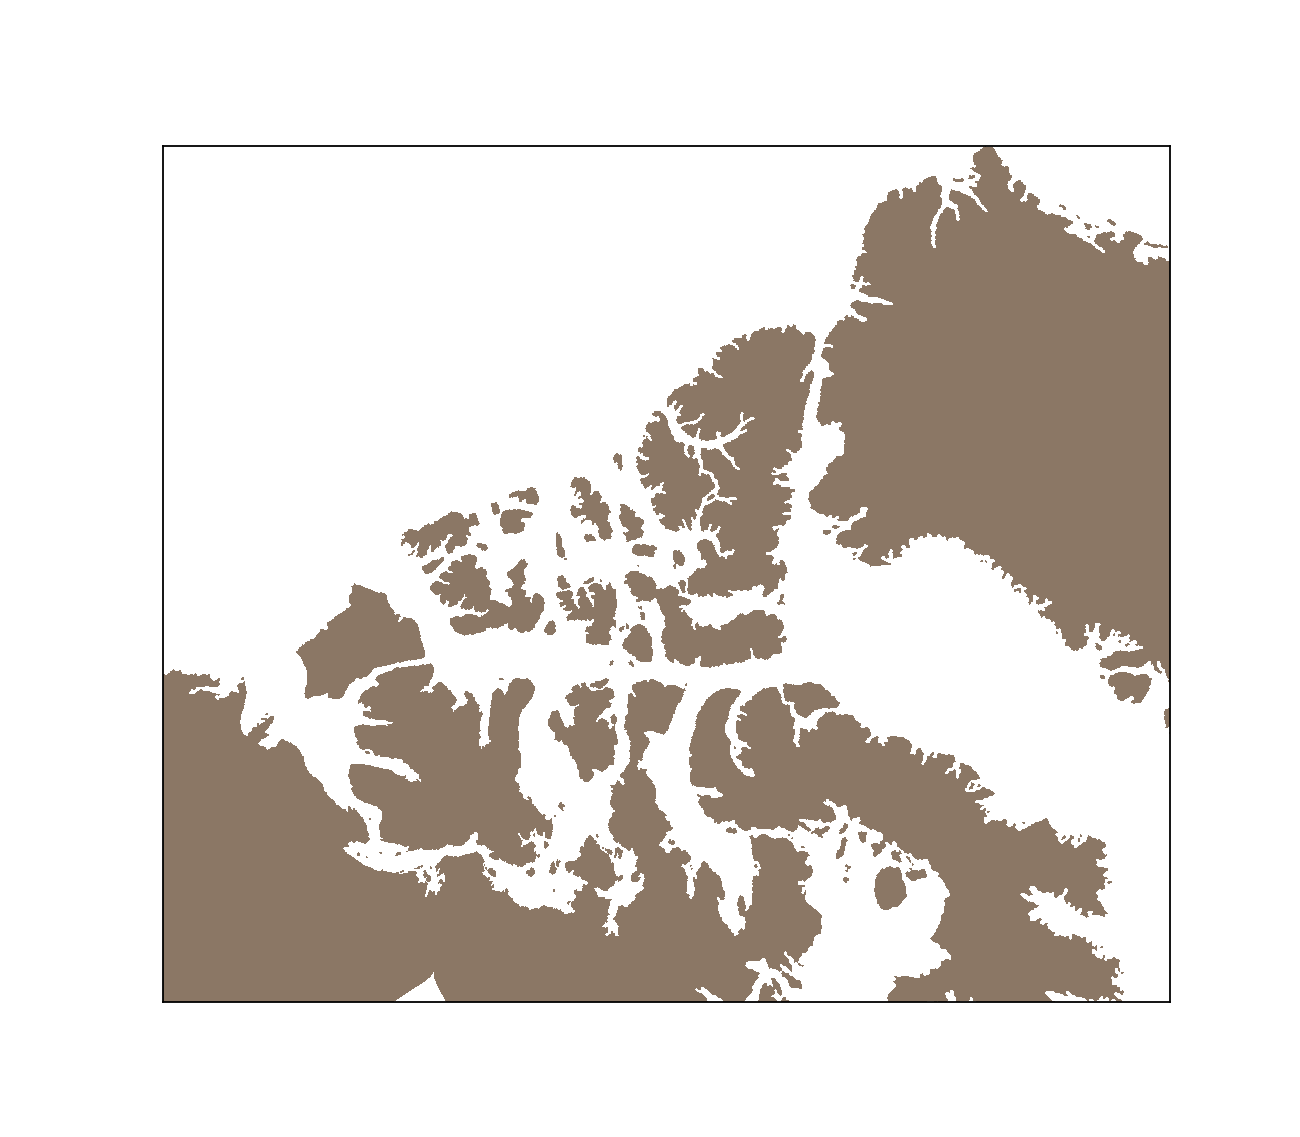

Time for plotting land mask using the pickle:  0.06967950599999995


In [18]:
t3 = time.process_time()

# load the pickle that was created above:
pickle.load(open('surface-map.pickle','rb'))
    
print('Time for plotting land mask using the pickle: ', time.process_time()-t3)

Much much faster! Now you can plot things on top of the Basemap object like usual:

In [28]:
# Load some sample data:
folder = '/data/brogalla/run_storage/'
file   = 'riv_base_2019-06-07T150256.762167-0400/ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020720-20020724.nc'
data   = nc.Dataset(folder+file)
dMn    = data.variables['dissolmn']

tmask       = tmask[0,:,1480:2050,200:800] # mask for my sub-domain
cond_tmask  = (tmask  < 0.1)
dMn_masked  = np.ma.masked_where(cond_tmask, dMn[0,:,:,:]) 

<IPython.core.display.Javascript object>


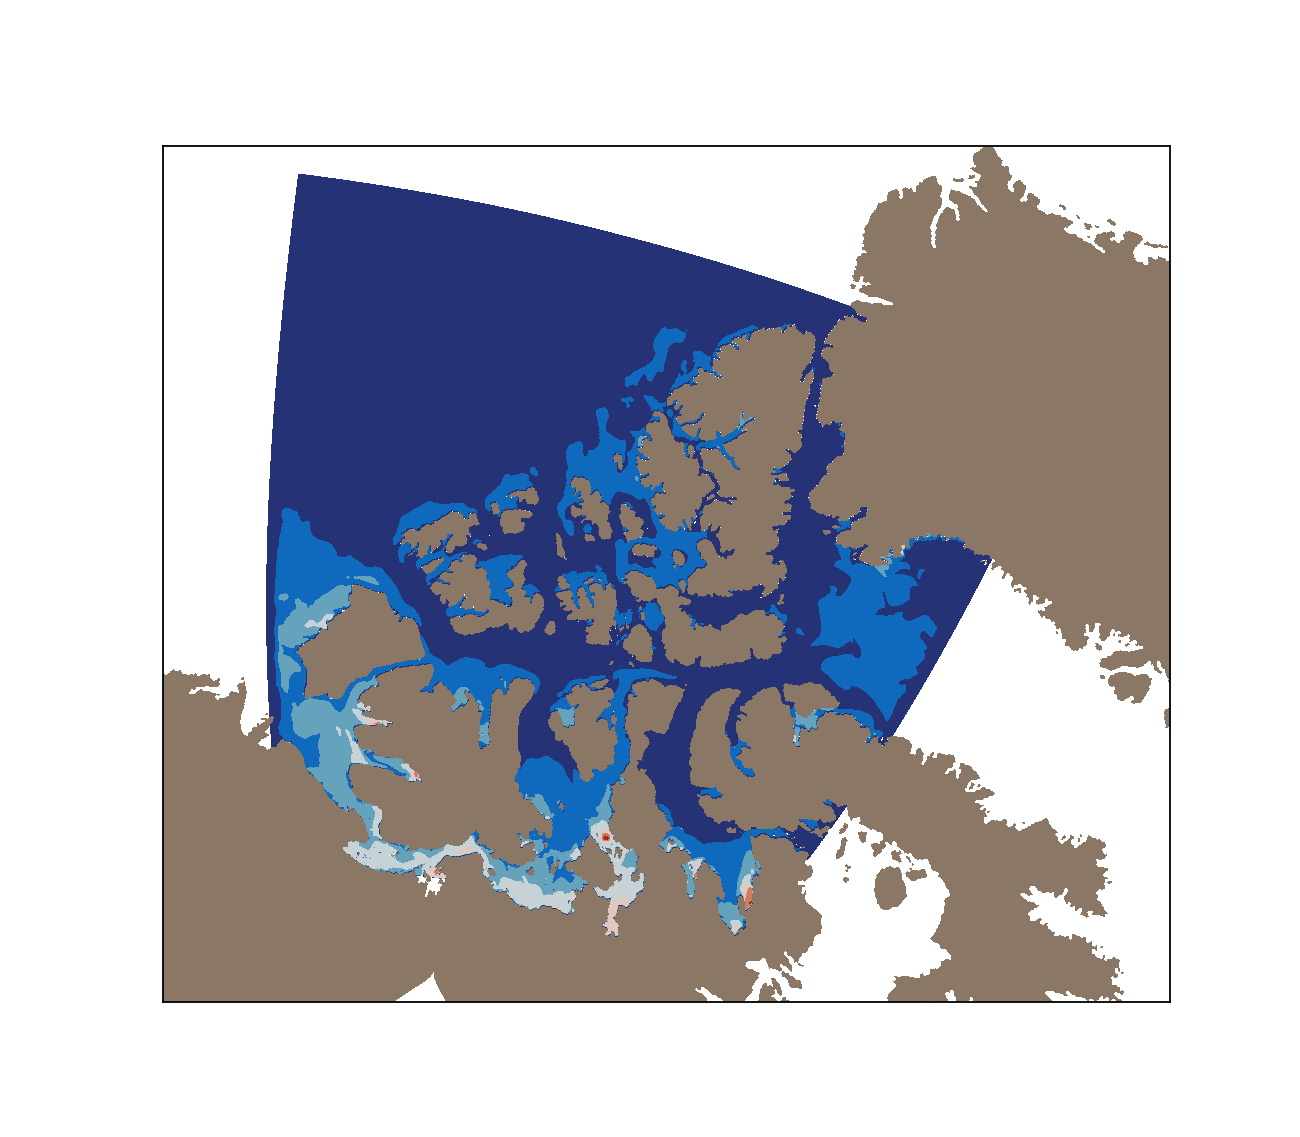

Time for plotting results with landmask:  1.207250794999993


In [30]:
t4 = time.process_time()

# Load the pickle that was created above:
proj = pickle.load(open('surface-map.pickle','rb'))

x1, y1 = proj(lon, lat) # note how it 'remembered' the projection and coordinates from the Basemap!

# My sub-domain and only plot the surface layer:
x = x1[1480:2050, 200:800]
y = y1[1480:2050, 200:800]
z = dMn_masked[0,:,:]

proj.contourf(x, y, z, cmap=cmocean.cm.balance)

print('Time for plotting results with landmask: ', time.process_time()-t4)